### All the Imports ###

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.model_selection import KFold
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from torchsummary import summary

### Loading Dataset ###

In [2]:
print(dir(datasets))

['CIFAR10', 'CIFAR100', 'CLEVRClassification', 'CREStereo', 'Caltech101', 'Caltech256', 'CarlaStereo', 'CelebA', 'Cityscapes', 'CocoCaptions', 'CocoDetection', 'Country211', 'DTD', 'DatasetFolder', 'EMNIST', 'ETH3DStereo', 'EuroSAT', 'FER2013', 'FGVCAircraft', 'FakeData', 'FallingThingsStereo', 'FashionMNIST', 'Flickr30k', 'Flickr8k', 'Flowers102', 'FlyingChairs', 'FlyingThings3D', 'Food101', 'GTSRB', 'HD1K', 'HMDB51', 'INaturalist', 'ImageFolder', 'ImageNet', 'Imagenette', 'InStereo2k', 'KMNIST', 'Kinetics', 'Kitti', 'Kitti2012Stereo', 'Kitti2015Stereo', 'KittiFlow', 'LFWPairs', 'LFWPeople', 'LSUN', 'LSUNClass', 'MNIST', 'Middlebury2014Stereo', 'MovingMNIST', 'Omniglot', 'OxfordIIITPet', 'PCAM', 'PhotoTour', 'Places365', 'QMNIST', 'RenderedSST2', 'SBDataset', 'SBU', 'SEMEION', 'STL10', 'SUN397', 'SVHN', 'SceneFlowStereo', 'Sintel', 'SintelStereo', 'StanfordCars', 'UCF101', 'USPS', 'VOCDetection', 'VOCSegmentation', 'VisionDataset', 'WIDERFace', '__all__', '__builtins__', '__cached__',

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

In [5]:
# Define data augmentation transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Width/height shift by 10%
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dtrain = datasets.CIFAR10(root='data',download=True,train=True,transform=transform_train)
dtest = datasets.CIFAR10(root='data',download=True,train=False,transform=transform_test)

100%|██████████| 170M/170M [00:05<00:00, 29.7MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [6]:
# View dataset properties
print(f"Train Dataset Length: {len(dtrain)}")
print(f"Test Dataset Length: {len(dtest)}")
print(f"Sample Data Type: {type(dtrain[0])}")

# Access first sample
image, label = dtrain[0]
print(f"Image Shape: {image.shape}")  # (C, H, W) format
print(f"Label: {label}")

# Check class labels
print(f"Classes: {dtrain.classes if hasattr(dtrain, 'classes') else 'No class labels available'}")

Train Dataset Length: 50000
Test Dataset Length: 10000
Sample Data Type: <class 'tuple'>
Image Shape: torch.Size([3, 32, 32])
Label: 6
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(dtrain, batch_size=batch_size)
test_dataloader = DataLoader(dtest, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 32, 32])
Shape of y: torch.Size([64]) torch.int64


### Model + Noise + Loss Definitions ###

In [8]:
class ConvBrunch(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super(ConvBrunch, self).__init__()
        padding = (kernel_size - 1) // 2
        self.out_conv = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_planes),
            nn.ReLU())

    def forward(self, x):
        return self.out_conv(x)

class CNN8(nn.Module):
    def __init__(self, type='CIFAR10'):
        super(CNN8, self).__init__()
        self.type = type
        if type == 'CIFAR10':
            self.block1 = nn.Sequential(
                ConvBrunch(3, 64, 3),
                ConvBrunch(64, 64, 3),
                nn.MaxPool2d(kernel_size=2, stride=2))
            self.block2 = nn.Sequential(
                ConvBrunch(64, 128, 3),
                ConvBrunch(128, 128, 3),
                nn.MaxPool2d(kernel_size=2, stride=2))
            self.block3 = nn.Sequential(
                ConvBrunch(128, 196, 3),
                ConvBrunch(196, 196, 3),
                nn.MaxPool2d(kernel_size=2, stride=2))
            # self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
            self.fc1 = nn.Sequential(
                nn.Linear(4*4*196, 256),
                nn.BatchNorm1d(256),
                nn.ReLU())
            self.fc2 = nn.Linear(256, 10)
            self.fc_size = 4*4*196
        self._reset_prams()

    def _reset_prams(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
        return

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        # x = self.global_avg_pool(x)
        # x = x.view(x.shape[0], -1)
        x = x.view(-1, self.fc_size)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [9]:
model = CNN8(type='CIFAR10').to(device=device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
        ConvBrunch-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
        ConvBrunch-8           [-1, 64, 32, 32]               0
         MaxPool2d-9           [-1, 64, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]          73,856
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
       ConvBrunch-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

In [10]:
class CrossEntropy(nn.Module):
    def __init__(self, num_classes=10):
        super(CrossEntropy, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, pred, labels):
        return self.ce_loss(pred, labels)


class ReverseCrossEntropy(nn.Module):
    def __init__(self, num_classes=10, scale=1.0, device=torch.device("cuda")):
        super(ReverseCrossEntropy, self).__init__()
        self.num_classes = num_classes
        self.scale = scale
        self.device = device

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        pred = torch.clamp(pred, min=1e-7, max=1.0)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        label_one_hot = torch.clamp(label_one_hot, min=1e-4, max=1.0)
        rce = (-1*torch.sum(pred * torch.log(label_one_hot), dim=1))
        return self.scale * rce.mean()


class NormalizedReverseCrossEntropy(nn.Module):
    def __init__(self, num_classes=10, scale=1.0, device=torch.device("cuda")):
        super(NormalizedReverseCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        pred = torch.clamp(pred, min=1e-7, max=1.0)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        label_one_hot = torch.clamp(label_one_hot, min=1e-4, max=1.0)
        normalizor = 1 / 4 * (self.num_classes - 1)
        rce = (-1*torch.sum(pred * torch.log(label_one_hot), dim=1))
        return self.scale * normalizor * rce.mean()


class NormalizedCrossEntropy(nn.Module):
    def __init__(self, num_classes=10, scale=1.0, device=torch.device("cuda")):
        super(NormalizedCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.log_softmax(pred, dim=1)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        nce = -1 * torch.sum(label_one_hot * pred, dim=1) / (- pred.sum(dim=1))
        return self.scale * nce.mean()


class MeanAbsoluteError(nn.Module):
    def __init__(self, num_classes=10, scale=1.0, device=torch.device("cuda")):
        super(MeanAbsoluteError, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale
        return

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        mae = 1. - torch.sum(label_one_hot * pred, dim=1)
        return self.scale * mae.mean()


class NormalizedMeanAbsoluteError(nn.Module):
    def __init__(self, num_classes=10, scale=1.0, device=torch.device("cuda")):
        super(NormalizedMeanAbsoluteError, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale
        return

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        normalizor = 1 / (2 * (self.num_classes - 1))
        mae = 1. - torch.sum(label_one_hot * pred, dim=1)
        return self.scale * normalizor * mae.mean()


class FocalLoss(nn.Module):
    '''
        https://github.com/clcarwin/focal_loss_pytorch/blob/master/focalloss.py
    '''

    def __init__(self, gamma=0.5, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)):
            self.alpha = torch.Tensor([alpha, 1-alpha])
        if isinstance(alpha, list):
            self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)                         # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))    # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = torch.autograd.Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * torch.autograd.Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()


class NormalizedFocalLoss(nn.Module):
    def __init__(self, scale=1.0, gamma=0, num_classes=10, alpha=None, size_average=True):
        super(NormalizedFocalLoss, self).__init__()
        self.gamma = gamma
        self.size_average = size_average
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, input, target):
        target = target.view(-1, 1)
        logpt = F.log_softmax(input, dim=1)
        normalizor = torch.sum(-1 * (1 - logpt.data.exp()) ** self.gamma * logpt, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = torch.autograd.Variable(logpt.data.exp())
        loss = -1 * (1-pt)**self.gamma * logpt
        loss = self.scale * loss / normalizor

        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()


# losses done - 4 possible combinations below

class NCEandRCE(torch.nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, num_classes=10):
        super(NCEandRCE, self).__init__()
        self.num_classes = num_classes
        self.nce = NormalizedCrossEntropy(scale=alpha, num_classes=num_classes)
        self.rce = ReverseCrossEntropy(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nce(pred, labels) + self.rce(pred, labels)


class NCEandMAE(torch.nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, num_classes=10):
        super(NCEandMAE, self).__init__()
        self.num_classes = num_classes
        self.nce = NormalizedCrossEntropy(scale=alpha, num_classes=num_classes)
        self.mae = MeanAbsoluteError(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nce(pred, labels) + self.mae(pred, labels)


class NFLandMAE(torch.nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, num_classes=10, gamma=0.5):
        super(NFLandMAE, self).__init__()
        self.num_classes = num_classes
        self.nfl = NormalizedFocalLoss(scale=alpha, gamma=gamma, num_classes=num_classes)
        self.mae = MeanAbsoluteError(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nfl(pred, labels) + self.mae(pred, labels)


class NFLandRCE(torch.nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, num_classes=10, gamma=0.5):
        super(NFLandRCE, self).__init__()
        self.num_classes = num_classes
        self.nfl = NormalizedFocalLoss(scale=alpha, gamma=gamma, num_classes=num_classes)
        self.rce = ReverseCrossEntropy(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nfl(pred, labels) + self.rce(pred, labels)


In [11]:
# robust loss - MAE, RCE
# normalized - NMAE, NRCE
# non robust - CE, FL
# made robust - NCE, NFL
# active loss - NCE, NFL
# passive loss - MAE, RCE
# 4 possible combinations - NCE + MAE, NCE + RCE, NFL + MAE, NFL + RCE

# Experiment 1 - robust(normalized) vs non robust test error
# Experiment 2 - best alpha, beta for each combination
# Experiment 3 - comparison across 4 possible combinations (best params of each)


In [12]:
def add_symmetric_noise(labels, noise_ratio):
    """Flip labels randomly to incorrect ones for symmetric noise."""
    noisy_labels = labels.clone()
    # num_classes = len(np.unique(labels))
    num_samples = len(labels)

    # Randomly flip labels
    for i in range(num_samples):
        if np.random.rand() < noise_ratio:
            # Randomly choose a new label that is different from the original
            new_label = np.random.randint(0, 10)
            while new_label == labels[i]:
                new_label = np.random.randint(0, 10)
            noisy_labels[i] = new_label

    return noisy_labels


def add_asymmetric_noise(labels, noise_ratio):
    """Flip labels within a specific set of classes for asymmetric noise."""
    noisy_labels = labels.clone()

    # Noise map: Flip classes as defined by the user (example for CIFAR-10)
    noise_map = {
        0: [1, 2],  # Flip class 0 to class 1 or class 2
        1: [2, 3],  # Flip class 1 to class 2 or class 3
        2: [3, 4],  # Flip class 2 to class 3 or class 4
        3: [4, 5],  # Flip class 3 to class 4 or class 5
        4: [5, 6],  # Flip class 4 to class 5 or class 6
        5: [6, 7],  # Flip class 5 to class 6 or class 7
        6: [7, 8],  # Flip class 6 to class 7 or class 8
        7: [8, 9],  # Flip class 7 to class 8 or class 9
        8: [9, 0],  # Flip class 8 to class 9 or class 0
        9: [0, 1],   # Flip class 9 to class 0 or class 1
        10:[0,1]
    }
    num_samples = len(labels)

    for i in range(num_samples):
        if np.random.rand() < noise_ratio:
            class_label = labels[i].item()
            if class_label in noise_map:
                new_label = np.random.choice(noise_map[class_label])
                noisy_labels[i] = new_label

    return noisy_labels

In [13]:
def train(dataloader, model, loss_fn, optimizer, scheduler, noise_type, noise_ratio):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        if noise_type == 'symmetric':
            y = add_symmetric_noise(y, noise_ratio)
        elif noise_type == 'asymmetric':
            y = add_asymmetric_noise(y, noise_ratio)
        else:
            pass
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]  lr: {scheduler.get_last_lr()[0]:.6f}")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct*100


### Train Using Original + Normalized Loss Functions ###

In [ ]:
# Initialize model, optimizer, and loss function
results = []
model = CNN8().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

loss_fn = CrossEntropy(num_classes=10)

noise_type = "symmetric"
noise_ratio = 0.6
epochs = 50
print(f"Loss Function: {loss_fn}")
R = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, scheduler, noise_type, noise_ratio)
    test_accuracy = test(test_dataloader, model, loss_fn)
    R.append(test_accuracy)
    scheduler.step()
results.append(R)
print("Done!")

Loss Function: CrossEntropy(
  (ce_loss): CrossEntropyLoss()
)
Epoch 1
-------------------------------
loss: 2.793710  [   64/50000]  lr: 0.010000
loss: 2.318467  [ 6464/50000]  lr: 0.010000
loss: 2.344282  [12864/50000]  lr: 0.010000
loss: 2.358395  [19264/50000]  lr: 0.010000
loss: 2.310346  [25664/50000]  lr: 0.010000
loss: 2.283321  [32064/50000]  lr: 0.010000
loss: 2.368474  [38464/50000]  lr: 0.010000
loss: 2.196866  [44864/50000]  lr: 0.010000
Test Error: 
 Accuracy: 42.3%, Avg loss: 1.905569 

Epoch 2
-------------------------------
loss: 2.247535  [   64/50000]  lr: 0.009755
loss: 2.386294  [ 6464/50000]  lr: 0.009755
loss: 2.218431  [12864/50000]  lr: 0.009755
loss: 2.279033  [19264/50000]  lr: 0.009755
loss: 2.184130  [25664/50000]  lr: 0.009755
loss: 2.341535  [32064/50000]  lr: 0.009755
loss: 2.253268  [38464/50000]  lr: 0.009755
loss: 2.254667  [44864/50000]  lr: 0.009755
Test Error: 
 Accuracy: 46.1%, Avg loss: 1.792587 

Epoch 3
-------------------------------
loss: 2.1

In [ ]:
# Initialize model, optimizer, and loss function

model = CNN8().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

loss_fn = NormalizedCrossEntropy(num_classes=10,scale=1.0, device=device)

noise_type = "symmetric"
noise_ratio = 0.6
epochs = 50
print(f"Loss Function: {loss_fn}")
R = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, scheduler, noise_type, noise_ratio)
    test_accuracy = test(test_dataloader, model, loss_fn)
    R.append(test_accuracy)
    scheduler.step()
results.append(R)
print("Done!")

Loss Function: NormalizedCrossEntropy()
Epoch 1
-------------------------------
loss: 0.104850  [   64/50000]  lr: 0.010000
loss: 0.094918  [ 6464/50000]  lr: 0.010000
loss: 0.096065  [12864/50000]  lr: 0.010000
loss: 0.097656  [19264/50000]  lr: 0.010000
loss: 0.088883  [25664/50000]  lr: 0.010000
loss: 0.098289  [32064/50000]  lr: 0.010000
loss: 0.082128  [38464/50000]  lr: 0.010000
loss: 0.074610  [44864/50000]  lr: 0.010000
Test Error: 
 Accuracy: 39.3%, Avg loss: 0.047080 

Epoch 2
-------------------------------
loss: 0.090286  [   64/50000]  lr: 0.009755
loss: 0.059314  [ 6464/50000]  lr: 0.009755
loss: 0.078668  [12864/50000]  lr: 0.009755
loss: 0.091339  [19264/50000]  lr: 0.009755
loss: 0.075476  [25664/50000]  lr: 0.009755
loss: 0.085597  [32064/50000]  lr: 0.009755
loss: 0.084187  [38464/50000]  lr: 0.009755
loss: 0.084283  [44864/50000]  lr: 0.009755
Test Error: 
 Accuracy: 43.8%, Avg loss: 0.039625 

Epoch 3
-------------------------------
loss: 0.083373  [   64/50000]  l

In [ ]:
df = pd.DataFrame(results)
# Save to CSV
df.to_csv("output.csv", index=False, header=False)

In [ ]:
# Initialize model, optimizer, and loss function

model = CNN8().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

loss_fn = MeanAbsoluteError(num_classes=10,scale=1.0, device=device)

noise_type = "symmetric"
noise_ratio = 0.6
epochs = 50
print(f"Loss Function: {loss_fn}")
R = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, scheduler, noise_type, noise_ratio)
    test_accuracy = test(test_dataloader, model, loss_fn)
    R.append(test_accuracy)
    scheduler.step()
results.append(R)
print("Done!")

Loss Function: MeanAbsoluteError()
Epoch 1
-------------------------------
loss: 0.906347  [   64/50000]  lr: 0.010000
loss: 0.889738  [ 6464/50000]  lr: 0.010000
loss: 0.837543  [12864/50000]  lr: 0.010000
loss: 0.834944  [19264/50000]  lr: 0.010000
loss: 0.856805  [25664/50000]  lr: 0.010000
loss: 0.768720  [32064/50000]  lr: 0.010000
loss: 0.784352  [38464/50000]  lr: 0.010000
loss: 0.824224  [44864/50000]  lr: 0.010000
Test Error: 
 Accuracy: 41.4%, Avg loss: 0.609582 

Epoch 2
-------------------------------
loss: 0.805480  [   64/50000]  lr: 0.009755
loss: 0.781008  [ 6464/50000]  lr: 0.009755
loss: 0.735179  [12864/50000]  lr: 0.009755
loss: 0.770329  [19264/50000]  lr: 0.009755
loss: 0.808879  [25664/50000]  lr: 0.009755
loss: 0.705389  [32064/50000]  lr: 0.009755
loss: 0.805247  [38464/50000]  lr: 0.009755
loss: 0.826379  [44864/50000]  lr: 0.009755
Test Error: 
 Accuracy: 49.7%, Avg loss: 0.526674 

Epoch 3
-------------------------------
loss: 0.752382  [   64/50000]  lr: 0.

In [ ]:
# Initialize model, optimizer, and loss function

model = CNN8().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

loss_fn = NormalizedMeanAbsoluteError(num_classes=10,scale=1.0, device=device)

noise_type = "symmetric"
noise_ratio = 0.6
epochs = 50
print(f"Loss Function: {loss_fn}")
R = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, scheduler, noise_type, noise_ratio)
    test_accuracy = test(test_dataloader, model, loss_fn)
    R.append(test_accuracy)
    scheduler.step()
results.append(R)
print("Done!")

Loss Function: NormalizedMeanAbsoluteError()
Epoch 1
-------------------------------
loss: 0.049357  [   64/50000]  lr: 0.010000
loss: 0.048575  [ 6464/50000]  lr: 0.010000
loss: 0.049214  [12864/50000]  lr: 0.010000
loss: 0.050089  [19264/50000]  lr: 0.010000
loss: 0.049845  [25664/50000]  lr: 0.010000
loss: 0.047013  [32064/50000]  lr: 0.010000
loss: 0.047563  [38464/50000]  lr: 0.010000
loss: 0.047461  [44864/50000]  lr: 0.010000
Test Error: 
 Accuracy: 25.4%, Avg loss: 0.043942 

Epoch 2
-------------------------------
loss: 0.047887  [   64/50000]  lr: 0.009755
loss: 0.047694  [ 6464/50000]  lr: 0.009755
loss: 0.044045  [12864/50000]  lr: 0.009755
loss: 0.048210  [19264/50000]  lr: 0.009755
loss: 0.048553  [25664/50000]  lr: 0.009755
loss: 0.046868  [32064/50000]  lr: 0.009755
loss: 0.045629  [38464/50000]  lr: 0.009755
loss: 0.049445  [44864/50000]  lr: 0.009755
Test Error: 
 Accuracy: 31.6%, Avg loss: 0.040632 

Epoch 3
-------------------------------
loss: 0.046596  [   64/5000

In [ ]:
df = pd.DataFrame(results)
# Save to CSV
df.to_csv("output.csv", index=False, header=False)

In [ ]:
# Initialize model, optimizer, and loss function

model = CNN8().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

loss_fn = FocalLoss()

noise_type = "symmetric"
noise_ratio = 0.6
epochs = 50
print(f"Loss Function: {loss_fn}")
R = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, scheduler, noise_type, noise_ratio)
    test_accuracy = test(test_dataloader, model, loss_fn)
    R.append(test_accuracy)
    scheduler.step()
results.append(R)
print("Done!")

Loss Function: FocalLoss()
Epoch 1
-------------------------------
loss: 2.470949  [   64/50000]  lr: 0.010000
loss: 2.207399  [ 6464/50000]  lr: 0.010000
loss: 2.117863  [12864/50000]  lr: 0.010000
loss: 2.211725  [19264/50000]  lr: 0.010000
loss: 2.209700  [25664/50000]  lr: 0.010000
loss: 2.181534  [32064/50000]  lr: 0.010000
loss: 2.202632  [38464/50000]  lr: 0.010000
loss: 2.058239  [44864/50000]  lr: 0.010000
Test Error: 
 Accuracy: 41.1%, Avg loss: 1.746634 

Epoch 2
-------------------------------
loss: 2.189688  [   64/50000]  lr: 0.009755
loss: 2.253740  [ 6464/50000]  lr: 0.009755
loss: 2.020547  [12864/50000]  lr: 0.009755
loss: 2.185122  [19264/50000]  lr: 0.009755
loss: 2.098230  [25664/50000]  lr: 0.009755
loss: 2.118615  [32064/50000]  lr: 0.009755
loss: 2.322720  [38464/50000]  lr: 0.009755
loss: 2.106426  [44864/50000]  lr: 0.009755
Test Error: 
 Accuracy: 48.0%, Avg loss: 1.694488 

Epoch 3
-------------------------------
loss: 2.183591  [   64/50000]  lr: 0.009045
l

In [ ]:
# Initialize model, optimizer, and loss function

model = CNN8().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

loss_fn = NormalizedFocalLoss(gamma=0.5)

noise_type = "symmetric"
noise_ratio = 0.6
epochs = 50
print(f"Loss Function: {loss_fn}")
R = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, scheduler, noise_type, noise_ratio)
    test_accuracy = test(test_dataloader, model, loss_fn)
    R.append(test_accuracy)
    scheduler.step()
results.append(R)
print("Done!")

Loss Function: NormalizedFocalLoss()
Epoch 1
-------------------------------
loss: 0.104071  [   64/50000]  lr: 0.010000
loss: 0.088502  [ 6464/50000]  lr: 0.010000
loss: 0.073551  [12864/50000]  lr: 0.010000
loss: 0.088952  [19264/50000]  lr: 0.010000
loss: 0.071782  [25664/50000]  lr: 0.010000
loss: 0.087059  [32064/50000]  lr: 0.010000
loss: 0.087167  [38464/50000]  lr: 0.010000
loss: 0.067570  [44864/50000]  lr: 0.010000
Test Error: 
 Accuracy: 40.3%, Avg loss: 0.043920 

Epoch 2
-------------------------------
loss: 0.096475  [   64/50000]  lr: 0.009755
loss: 0.089738  [ 6464/50000]  lr: 0.009755
loss: 0.077983  [12864/50000]  lr: 0.009755
loss: 0.081508  [19264/50000]  lr: 0.009755
loss: 0.072336  [25664/50000]  lr: 0.009755
loss: 0.083952  [32064/50000]  lr: 0.009755
loss: 0.078842  [38464/50000]  lr: 0.009755
loss: 0.080147  [44864/50000]  lr: 0.009755
Test Error: 
 Accuracy: 44.3%, Avg loss: 0.036859 

Epoch 3
-------------------------------
loss: 0.082621  [   64/50000]  lr: 

In [ ]:
df = pd.DataFrame(results)
# Save to CSV
df.to_csv("output.csv", index=False, header=False)

In [ ]:
# Initialize model, optimizer, and loss function

model = CNN8().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

loss_fn = ReverseCrossEntropy(num_classes=10,scale=1.0, device=device)

noise_type = "symmetric"
noise_ratio = 0.6
epochs = 50
print(f"Loss Function: {loss_fn}")
R = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, scheduler, noise_type, noise_ratio)
    test_accuracy = test(test_dataloader, model, loss_fn)
    R.append(test_accuracy)
    scheduler.step()
results.append(R)
print("Done!")

Loss Function: ReverseCrossEntropy()
Epoch 1
-------------------------------
loss: 8.352514  [   64/50000]  lr: 0.010000
loss: 7.334435  [ 6464/50000]  lr: 0.010000
loss: 8.045234  [12864/50000]  lr: 0.010000
loss: 7.453058  [19264/50000]  lr: 0.010000
loss: 7.029572  [25664/50000]  lr: 0.010000
loss: 7.873847  [32064/50000]  lr: 0.010000
loss: 8.219972  [38464/50000]  lr: 0.010000
loss: 7.576798  [44864/50000]  lr: 0.010000
Test Error: 
 Accuracy: 28.9%, Avg loss: 6.570768 

Epoch 2
-------------------------------
loss: 8.116982  [   64/50000]  lr: 0.009755
loss: 7.686055  [ 6464/50000]  lr: 0.009755
loss: 6.961660  [12864/50000]  lr: 0.009755
loss: 8.042016  [19264/50000]  lr: 0.009755
loss: 7.631546  [25664/50000]  lr: 0.009755
loss: 7.407514  [32064/50000]  lr: 0.009755
loss: 7.880955  [38464/50000]  lr: 0.009755
loss: 7.787077  [44864/50000]  lr: 0.009755
Test Error: 
 Accuracy: 33.8%, Avg loss: 6.119444 

Epoch 3
-------------------------------
loss: 7.764878  [   64/50000]  lr: 

In [ ]:
# Initialize model, optimizer, and loss function

model = CNN8().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

loss_fn = NormalizedReverseCrossEntropy(num_classes=10,scale=1.0, device=device)

noise_type = "symmetric"
noise_ratio = 0.6
epochs = 50
print(f"Loss Function: {loss_fn}")
R = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, scheduler, noise_type, noise_ratio)
    test_accuracy = test(test_dataloader, model, loss_fn)
    R.append(test_accuracy)
    scheduler.step()
results.append(R)
print("Done!")

Loss Function: NormalizedReverseCrossEntropy()
Epoch 1
-------------------------------
loss: 18.489332  [   64/50000]  lr: 0.010000
loss: 17.534971  [ 6464/50000]  lr: 0.010000
loss: 18.760948  [12864/50000]  lr: 0.010000
loss: 18.142246  [19264/50000]  lr: 0.010000
loss: 16.130709  [25664/50000]  lr: 0.010000
loss: 17.920630  [32064/50000]  lr: 0.010000
loss: 18.096527  [38464/50000]  lr: 0.010000
loss: 16.474792  [44864/50000]  lr: 0.010000
Test Error: 
 Accuracy: 27.3%, Avg loss: 15.072282 

Epoch 2
-------------------------------
loss: 16.548580  [   64/50000]  lr: 0.009755
loss: 18.205164  [ 6464/50000]  lr: 0.009755
loss: 18.896143  [12864/50000]  lr: 0.009755
loss: 17.823395  [19264/50000]  lr: 0.009755
loss: 16.761623  [25664/50000]  lr: 0.009755
loss: 17.454407  [32064/50000]  lr: 0.009755
loss: 19.410961  [38464/50000]  lr: 0.009755
loss: 19.309216  [44864/50000]  lr: 0.009755
Test Error: 
 Accuracy: 30.0%, Avg loss: 14.497078 

Epoch 3
-------------------------------
loss: 1

In [ ]:
df = pd.DataFrame(results)
# Save to CSV
df.to_csv("output.csv", index=False, header=False)

###APL for Symmetric Noise ###

In [ ]:
# Initialize model, optimizer, and loss function
results = []
model = CNN8().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

loss_fn = NCEandMAE()

noise_type = "symmetric"
noise_ratio = 0.6
epochs = 50
print(f"Loss Function: {loss_fn}")
R = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, scheduler, noise_type, noise_ratio)
    test_accuracy = test(test_dataloader, model, loss_fn)
    R.append(test_accuracy)
    scheduler.step()
results.append(R)
print("Done!")

Loss Function: NCEandMAE(
  (nce): NormalizedCrossEntropy()
  (mae): MeanAbsoluteError()
)
Epoch 1
-------------------------------
loss: 1.006562  [   64/50000]  lr: 0.010000
loss: 0.970413  [ 6464/50000]  lr: 0.010000
loss: 0.871807  [12864/50000]  lr: 0.010000
loss: 0.972873  [19264/50000]  lr: 0.010000
loss: 0.863977  [25664/50000]  lr: 0.010000
loss: 0.847083  [32064/50000]  lr: 0.010000
loss: 0.878798  [38464/50000]  lr: 0.010000
loss: 0.906233  [44864/50000]  lr: 0.010000
Test Error: 
 Accuracy: 45.9%, Avg loss: 0.605870 

Epoch 2
-------------------------------
loss: 0.877906  [   64/50000]  lr: 0.009755
loss: 0.952029  [ 6464/50000]  lr: 0.009755
loss: 0.863979  [12864/50000]  lr: 0.009755
loss: 0.852342  [19264/50000]  lr: 0.009755
loss: 0.839996  [25664/50000]  lr: 0.009755
loss: 0.881778  [32064/50000]  lr: 0.009755
loss: 0.879677  [38464/50000]  lr: 0.009755
loss: 0.947100  [44864/50000]  lr: 0.009755
Test Error: 
 Accuracy: 52.8%, Avg loss: 0.526156 

Epoch 3
-------------

In [ ]:
# Initialize model, optimizer, and loss function

model = CNN8().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

loss_fn = NCEandRCE()

noise_type = "symmetric"
noise_ratio = 0.6
epochs = 50
print(f"Loss Function: {loss_fn}")
R = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, scheduler, noise_type, noise_ratio)
    test_accuracy = test(test_dataloader, model, loss_fn)
    R.append(test_accuracy)
    scheduler.step()
results.append(R)
print("Done!")

Loss Function: NCEandRCE(
  (nce): NormalizedCrossEntropy()
  (rce): ReverseCrossEntropy()
)
Epoch 1
-------------------------------
loss: 8.362288  [   64/50000]  lr: 0.010000
loss: 8.323055  [ 6464/50000]  lr: 0.010000
loss: 8.036539  [12864/50000]  lr: 0.010000
loss: 7.947402  [19264/50000]  lr: 0.010000
loss: 7.902166  [25664/50000]  lr: 0.010000
loss: 7.635753  [32064/50000]  lr: 0.010000
loss: 7.864632  [38464/50000]  lr: 0.010000
loss: 7.750090  [44864/50000]  lr: 0.010000
Test Error: 
 Accuracy: 36.7%, Avg loss: 5.921740 

Epoch 2
-------------------------------
loss: 7.363238  [   64/50000]  lr: 0.009755
loss: 7.322523  [ 6464/50000]  lr: 0.009755
loss: 7.570503  [12864/50000]  lr: 0.009755
loss: 7.893799  [19264/50000]  lr: 0.009755
loss: 8.437712  [25664/50000]  lr: 0.009755
loss: 7.930798  [32064/50000]  lr: 0.009755
loss: 8.217038  [38464/50000]  lr: 0.009755
loss: 8.387280  [44864/50000]  lr: 0.009755
Test Error: 
 Accuracy: 37.9%, Avg loss: 5.799737 

Epoch 3
-----------

In [ ]:
# Initialize model, optimizer, and loss function

model = CNN8().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

loss_fn = NFLandMAE()

noise_type = "symmetric"
noise_ratio = 0.6
epochs = 50
print(f"Loss Function: {loss_fn}")
R = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, scheduler, noise_type, noise_ratio)
    test_accuracy = test(test_dataloader, model, loss_fn)
    R.append(test_accuracy)
    scheduler.step()
results.append(R)
print("Done!")

Loss Function: NFLandMAE(
  (nfl): NormalizedFocalLoss()
  (mae): MeanAbsoluteError()
)
Epoch 1
-------------------------------
loss: 0.998267  [   64/50000]  lr: 0.010000
loss: 0.902996  [ 6464/50000]  lr: 0.010000
loss: 0.961706  [12864/50000]  lr: 0.010000
loss: 0.907562  [19264/50000]  lr: 0.010000
loss: 0.918315  [25664/50000]  lr: 0.010000
loss: 0.901033  [32064/50000]  lr: 0.010000
loss: 0.907996  [38464/50000]  lr: 0.010000
loss: 0.856619  [44864/50000]  lr: 0.010000
Test Error: 
 Accuracy: 46.6%, Avg loss: 0.599136 

Epoch 2
-------------------------------
loss: 0.932849  [   64/50000]  lr: 0.009755
loss: 0.810373  [ 6464/50000]  lr: 0.009755
loss: 0.926585  [12864/50000]  lr: 0.009755
loss: 0.904927  [19264/50000]  lr: 0.009755
loss: 0.899043  [25664/50000]  lr: 0.009755
loss: 0.832149  [32064/50000]  lr: 0.009755
loss: 0.863259  [38464/50000]  lr: 0.009755
loss: 0.903472  [44864/50000]  lr: 0.009755
Test Error: 
 Accuracy: 50.5%, Avg loss: 0.549888 

Epoch 3
----------------

In [ ]:
# Initialize model, optimizer, and loss function

model = CNN8().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

loss_fn = NFLandRCE()

noise_type = "symmetric"
noise_ratio = 0.6
epochs = 50
print(f"Loss Function: {loss_fn}")
R = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, scheduler, noise_type, noise_ratio)
    test_accuracy = test(test_dataloader, model, loss_fn)
    R.append(test_accuracy)
    scheduler.step()
results.append(R)
print("Done!")


Loss Function: NFLandRCE(
  (nfl): NormalizedFocalLoss()
  (rce): ReverseCrossEntropy()
)
Epoch 1
-------------------------------
loss: 8.418543  [   64/50000]  lr: 0.010000
loss: 8.476891  [ 6464/50000]  lr: 0.010000
loss: 6.991764  [12864/50000]  lr: 0.010000
loss: 8.716045  [19264/50000]  lr: 0.010000
loss: 7.531748  [25664/50000]  lr: 0.010000
loss: 7.848363  [32064/50000]  lr: 0.010000
loss: 8.512876  [38464/50000]  lr: 0.010000
loss: 7.294911  [44864/50000]  lr: 0.010000
Test Error: 
 Accuracy: 35.5%, Avg loss: 6.060528 

Epoch 2
-------------------------------
loss: 7.722759  [   64/50000]  lr: 0.009755
loss: 7.826994  [ 6464/50000]  lr: 0.009755
loss: 7.273664  [12864/50000]  lr: 0.009755
loss: 7.434256  [19264/50000]  lr: 0.009755
loss: 7.537266  [25664/50000]  lr: 0.009755
loss: 8.045879  [32064/50000]  lr: 0.009755
loss: 7.324730  [38464/50000]  lr: 0.009755
loss: 7.462530  [44864/50000]  lr: 0.009755
Test Error: 
 Accuracy: 37.9%, Avg loss: 5.781695 

Epoch 3
--------------

In [ ]:
df = pd.DataFrame(results)
# Save to CSV
df.to_csv("output.csv", index=False, header=False)

In [ ]:
results2 = pd.read_csv("output2.csv")
results2 = results2.transpose().reset_index()


In [ ]:
results2.columns

Index(['index', 0, 1, 2, 3, 4, 5, 6], dtype='object')

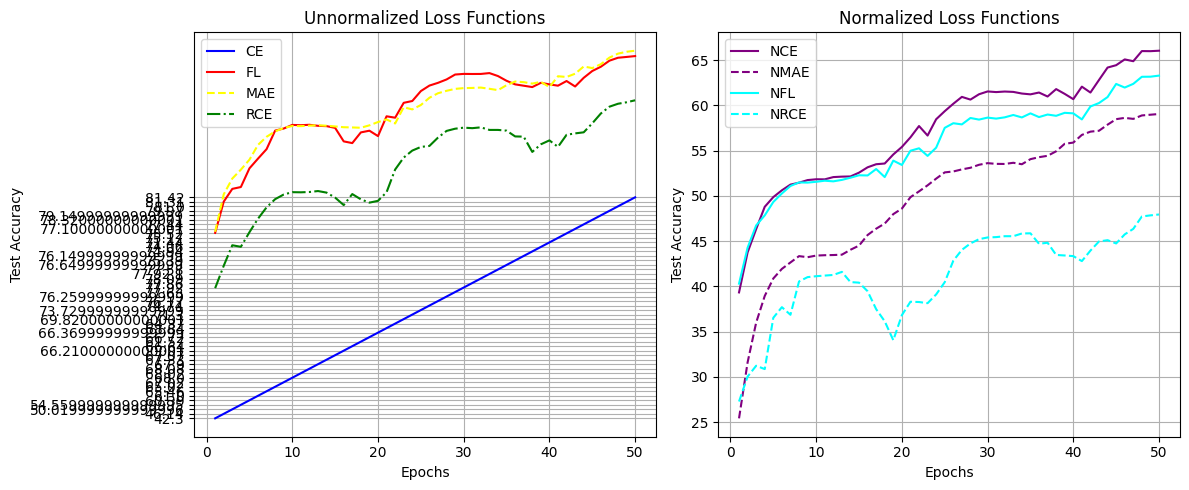

In [ ]:
epochs = [i for i in range(1,51,1)]  # 50 epochs
test_accuracy_CE = results2['index'].tolist()
test_accuracy_FL = results2[3].tolist()
test_accuracy_NCE = results2[0].tolist()
test_accuracy_NFL = results2[4].tolist()

test_accuracy_MAE = results2[1].tolist()
test_accuracy_NMAE = results2[2].tolist()
test_accuracy_RCE = results2[5].tolist()
test_accuracy_NRCE = results2[6].tolist()

# Create the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot for unnormalized loss functions
axs[0].plot(epochs, test_accuracy_CE, label='CE', color='blue', linestyle='-')
axs[0].plot(epochs, test_accuracy_FL, label='FL', color='red', linestyle='-')
axs[0].plot(epochs, test_accuracy_MAE, label='MAE', color='yellow', linestyle='--')
axs[0].plot(epochs, test_accuracy_RCE, label='RCE', color='green', linestyle='-.')
axs[0].set_title("Unnormalized Loss Functions")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Test Accuracy")
axs[0].legend()
axs[0].grid()

# Plot for normalized loss functions
axs[1].plot(epochs, test_accuracy_NCE, label='NCE', color='purple', linestyle='-')
axs[1].plot(epochs, test_accuracy_NMAE, label='NMAE', color='purple', linestyle='--')
axs[1].plot(epochs, test_accuracy_NFL, label='NFL', color='cyan', linestyle='-')
axs[1].plot(epochs, test_accuracy_NRCE, label='NRCE', color='cyan', linestyle='--')
axs[1].set_title("Normalized Loss Functions")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Test Accuracy")
axs[1].legend()
axs[1].grid()

# Adjust layout and show plot
plt.tight_layout()

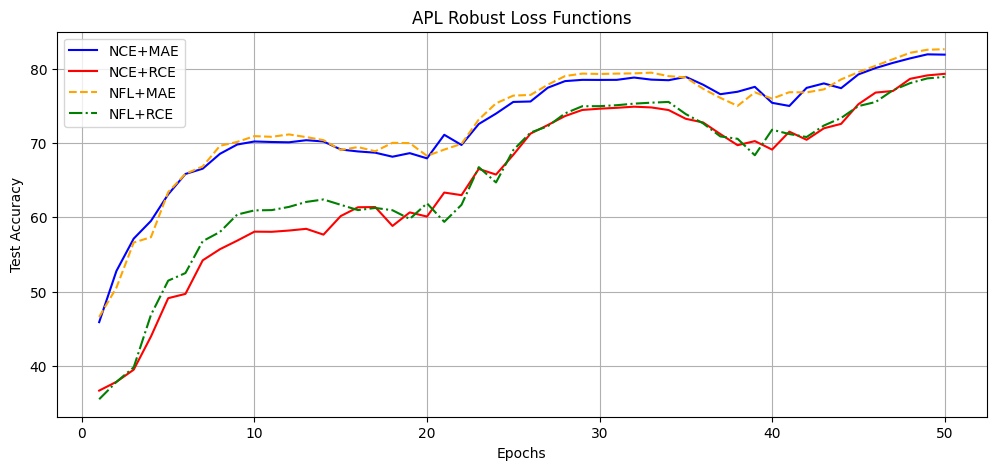

In [ ]:
test_accuracy_NCE_MAE = results[0]
test_accuracy_NCE_RCE = results[1]
test_accuracy_NFL_MAE = results[2]
test_accuracy_NFL_RCE = results[3]


# Create the figure and subplots
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
epochs = [i for i in range(1,51,1)]
# Plot for unnormalized loss functions
axs.plot(epochs, test_accuracy_NCE_MAE, label='NCE+MAE', color='blue', linestyle='-')
axs.plot(epochs, test_accuracy_NCE_RCE, label='NCE+RCE', color='red', linestyle='-')
axs.plot(epochs, test_accuracy_NFL_MAE, label='NFL+MAE', color='orange', linestyle='--')
axs.plot(epochs, test_accuracy_NFL_RCE, label='NFL+RCE', color='green', linestyle='-.')
axs.set_title("APL Robust Loss Functions")
axs.set_xlabel("Epochs")
axs.set_ylabel("Test Accuracy")
axs.legend()
axs.grid()

###APL for Asymmetric Noise ###

In [14]:
# Initialize model, optimizer, and loss function
results = []
model = CNN8().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

loss_fn = NCEandMAE()

noise_type = "asymmetric"
noise_ratio = 0.6
epochs = 50
print(f"Loss Function: {loss_fn}")
R = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, scheduler, noise_type, noise_ratio)
    test_accuracy = test(test_dataloader, model, loss_fn)
    R.append(test_accuracy)
    scheduler.step()
results.append(R)
print("Done!")

Loss Function: NCEandMAE(
  (nce): NormalizedCrossEntropy()
  (mae): MeanAbsoluteError()
)
Epoch 1
-------------------------------
loss: 1.004831  [   64/50000]  lr: 0.010000
loss: 0.863320  [ 6464/50000]  lr: 0.010000
loss: 0.836647  [12864/50000]  lr: 0.010000
loss: 0.896583  [19264/50000]  lr: 0.010000
loss: 0.807943  [25664/50000]  lr: 0.010000
loss: 0.894162  [32064/50000]  lr: 0.010000
loss: 0.861834  [38464/50000]  lr: 0.010000
loss: 0.841430  [44864/50000]  lr: 0.010000
Test Error: 
 Accuracy: 34.9%, Avg loss: 0.713949 

Epoch 2
-------------------------------
loss: 0.787834  [   64/50000]  lr: 0.009755
loss: 0.797488  [ 6464/50000]  lr: 0.009755
loss: 0.741427  [12864/50000]  lr: 0.009755
loss: 0.725554  [19264/50000]  lr: 0.009755
loss: 0.841943  [25664/50000]  lr: 0.009755
loss: 0.817231  [32064/50000]  lr: 0.009755
loss: 0.794746  [38464/50000]  lr: 0.009755
loss: 0.880639  [44864/50000]  lr: 0.009755
Test Error: 
 Accuracy: 40.2%, Avg loss: 0.658327 

Epoch 3
-------------

In [15]:
# Initialize model, optimizer, and loss function
model = CNN8().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

loss_fn = NFLandRCE()

noise_type = "asymmetric"
noise_ratio = 0.6
epochs = 50
print(f"Loss Function: {loss_fn}")
R = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, scheduler, noise_type, noise_ratio)
    test_accuracy = test(test_dataloader, model, loss_fn)
    R.append(test_accuracy)
    scheduler.step()
results.append(R)
print("Done!")

Loss Function: NFLandRCE(
  (nfl): NormalizedFocalLoss()
  (rce): ReverseCrossEntropy()
)
Epoch 1
-------------------------------
loss: 8.242146  [   64/50000]  lr: 0.010000
loss: 6.573759  [ 6464/50000]  lr: 0.010000
loss: 6.961482  [12864/50000]  lr: 0.010000
loss: 7.904403  [19264/50000]  lr: 0.010000
loss: 8.200678  [25664/50000]  lr: 0.010000
loss: 7.526087  [32064/50000]  lr: 0.010000
loss: 8.027898  [38464/50000]  lr: 0.010000
loss: 7.083772  [44864/50000]  lr: 0.010000
Test Error: 
 Accuracy: 26.5%, Avg loss: 6.846934 

Epoch 2
-------------------------------
loss: 7.652888  [   64/50000]  lr: 0.009755
loss: 7.303679  [ 6464/50000]  lr: 0.009755
loss: 7.351525  [12864/50000]  lr: 0.009755
loss: 6.551526  [19264/50000]  lr: 0.009755
loss: 8.013631  [25664/50000]  lr: 0.009755
loss: 7.295154  [32064/50000]  lr: 0.009755
loss: 7.829012  [38464/50000]  lr: 0.009755
loss: 7.713206  [44864/50000]  lr: 0.009755
Test Error: 
 Accuracy: 31.5%, Avg loss: 6.373233 

Epoch 3
--------------

In [16]:
# Initialize model, optimizer, and loss function
model = CNN8().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

loss_fn = NFLandMAE()

noise_type = "asymmetric"
noise_ratio = 0.6
epochs = 50
print(f"Loss Function: {loss_fn}")
R = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, scheduler, noise_type, noise_ratio)
    test_accuracy = test(test_dataloader, model, loss_fn)
    R.append(test_accuracy)
    scheduler.step()
results.append(R)
print("Done!")

Loss Function: NFLandMAE(
  (nfl): NormalizedFocalLoss()
  (mae): MeanAbsoluteError()
)
Epoch 1
-------------------------------
loss: 1.015924  [   64/50000]  lr: 0.010000
loss: 0.808735  [ 6464/50000]  lr: 0.010000
loss: 0.814233  [12864/50000]  lr: 0.010000
loss: 0.827728  [19264/50000]  lr: 0.010000
loss: 0.850974  [25664/50000]  lr: 0.010000
loss: 0.819593  [32064/50000]  lr: 0.010000
loss: 0.727044  [38464/50000]  lr: 0.010000
loss: 0.821281  [44864/50000]  lr: 0.010000
Test Error: 
 Accuracy: 37.4%, Avg loss: 0.693043 

Epoch 2
-------------------------------
loss: 0.835698  [   64/50000]  lr: 0.009755
loss: 0.778004  [ 6464/50000]  lr: 0.009755
loss: 0.809175  [12864/50000]  lr: 0.009755
loss: 0.763147  [19264/50000]  lr: 0.009755
loss: 0.821419  [25664/50000]  lr: 0.009755
loss: 0.859922  [32064/50000]  lr: 0.009755
loss: 0.834776  [38464/50000]  lr: 0.009755
loss: 0.878344  [44864/50000]  lr: 0.009755
Test Error: 
 Accuracy: 42.4%, Avg loss: 0.630995 

Epoch 3
----------------

In [17]:
# Initialize model, optimizer, and loss function
model = CNN8().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

loss_fn = NCEandRCE()

noise_type = "asymmetric"
noise_ratio = 0.6
epochs = 50
print(f"Loss Function: {loss_fn}")
R = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, scheduler, noise_type, noise_ratio)
    test_accuracy = test(test_dataloader, model, loss_fn)
    R.append(test_accuracy)
    scheduler.step()
results.append(R)
print("Done!")

Loss Function: NCEandRCE(
  (nce): NormalizedCrossEntropy()
  (rce): ReverseCrossEntropy()
)
Epoch 1
-------------------------------
loss: 8.428314  [   64/50000]  lr: 0.010000
loss: 7.712672  [ 6464/50000]  lr: 0.010000
loss: 6.690663  [12864/50000]  lr: 0.010000
loss: 7.618881  [19264/50000]  lr: 0.010000
loss: 7.056591  [25664/50000]  lr: 0.010000
loss: 7.655952  [32064/50000]  lr: 0.010000
loss: 6.832937  [38464/50000]  lr: 0.010000
loss: 7.325710  [44864/50000]  lr: 0.010000
Test Error: 
 Accuracy: 27.6%, Avg loss: 6.732715 

Epoch 2
-------------------------------
loss: 8.159618  [   64/50000]  lr: 0.009755
loss: 6.971975  [ 6464/50000]  lr: 0.009755
loss: 7.577303  [12864/50000]  lr: 0.009755
loss: 7.638403  [19264/50000]  lr: 0.009755
loss: 7.326095  [25664/50000]  lr: 0.009755
loss: 7.080830  [32064/50000]  lr: 0.009755
loss: 6.761780  [38464/50000]  lr: 0.009755
loss: 7.019152  [44864/50000]  lr: 0.009755
Test Error: 
 Accuracy: 30.4%, Avg loss: 6.479504 

Epoch 3
-----------

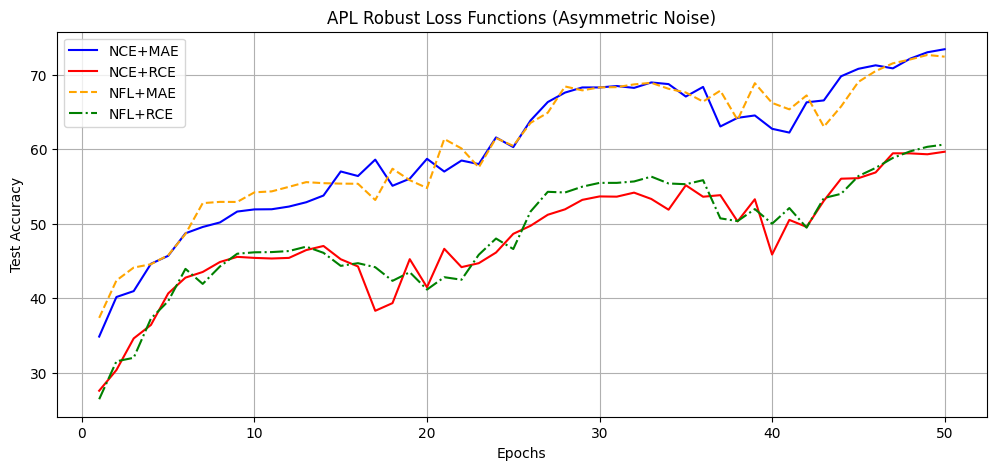

In [18]:
test_accuracy_NCE_MAE = results[0]
test_accuracy_NCE_RCE = results[3]
test_accuracy_NFL_MAE = results[2]
test_accuracy_NFL_RCE = results[1]


# Create the figure and subplots
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
epochs = [i for i in range(1,51,1)]
# Plot for unnormalized loss functions
axs.plot(epochs, test_accuracy_NCE_MAE, label='NCE+MAE', color='blue', linestyle='-')
axs.plot(epochs, test_accuracy_NCE_RCE, label='NCE+RCE', color='red', linestyle='-')
axs.plot(epochs, test_accuracy_NFL_MAE, label='NFL+MAE', color='orange', linestyle='--')
axs.plot(epochs, test_accuracy_NFL_RCE, label='NFL+RCE', color='green', linestyle='-.')
axs.set_title("APL Robust Loss Functions (Asymmetric Noise)")
axs.set_xlabel("Epochs")
axs.set_ylabel("Test Accuracy")
axs.legend()
axs.grid()